In [ ]:
!pip install transformers
import torch
import torch.nn as nn
import numpy as np
from transformers import ViTModel
from transformers import ViTModel, ViTConfig
from torch.optim import Adam
from tqdm import tqdm
import os
from skimage.transform import resize
from skimage.io import imread

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

TRAIN_INDICES_FILE = 'train_indices.txt'
TEST_INDICES_FILE = 'test_indices.txt'


In [ ]:
!unzip /content/drive/MyDrive/MRIdataset.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: MRIdataset/Non_Demented/non_1757.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_1757.jpg  
  inflating: MRIdataset/Non_Demented/non_3168.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_3168.jpg  
  inflating: MRIdataset/Non_Demented/non_2276.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2276.jpg  
  inflating: MRIdataset/Non_Demented/non_1019.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_1019.jpg  
  inflating: MRIdataset/Non_Demented/non_683.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_683.jpg  
  inflating: MRIdataset/Non_Demented/non_2510.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2510.jpg  
  inflating: MRIdataset/Non_Demented/non_2504.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_2504.jpg  
  inflating: MRIdataset/Non_Demented/non_697.jpg  
  inflating: __MACOSX/MRIdataset/Non_Demented/._non_697.jpg  
  inflating: MRIdataset/Non_Demented/non_2262.jpg  
  inf

In [ ]:
# from datasets import load_dataset
# Load dataset
import os
DIR = '/content/MRIdataset'
os.path.exists(DIR)
os.listdir(DIR)
datadir='/content/MRIdataset'

In [ ]:

class MRIDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# your loading code
Categories=['Mild_Demented','Moderate_Demented','Very_Mild_Demented','Non_Demented']
flat_data_arr=[] #input array
target_arr=[] #output array
!pip install -q datasets

from datasets import load_dataset
import os

# Load dataset

for i in Categories:
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        # print(img_array.shape)
        img_resized=resize(img_array,(224,224,3))
        img_resized = np.transpose(img_resized, (2, 0, 1))
        flat_data_arr.append(img_resized)
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')

# convert your data to tensors
flat_data_arr = [torch.from_numpy(img).float() for img in flat_data_arr]
target_arr = torch.tensor(target_arr, dtype=torch.long)
torch.cuda.is_available()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
loading... category : Mild_Demented
loaded category:Mild_Demented successfully
loading... category : Moderate_Demented
loaded category:Moderate_Demented successfully
loading... category : Very_Mild_Demented
loaded category:Very_Mild_Demented successfully
loading... category : Non_Demented
loaded category:Non_Demented successfully


True

In [ ]:
import os

with open(os.path.join('/content/drive/MyDrive/', TRAIN_INDICES_FILE), 'r') as f:
    train_indices = f.readlines()

with open(os.path.join('/content/drive/MyDrive/', TEST_INDICES_FILE), 'r') as f:
    test_indices = f.readlines()

print("training data size: ", len(train_indices))
print("testing data size: ", len(test_indices))
print(len(flat_data_arr))

### double check no overlap between train and test
for i in train_indices:
    if i in test_indices:
        print("overlap")
train_data = [flat_data_arr[int(i)] for i in train_indices]
test_data = [flat_data_arr[int(i)] for i in test_indices]
train_target = [target_arr[int(i)] for i in train_indices]
test_target = [target_arr[int(i)] for i in test_indices]

train_dataset = MRIDataset(train_data, train_target)
test_dataset = MRIDataset(test_data, test_target)
# train_dataset = MRIDataset(flat_data_arr[train_indices], target_arr[train_indices])
# test_dataset = MRIDataset(flat_data_arr[test_indices], target_arr[test_indices])


training data size:  5120
testing data size:  1280
6400


In [ ]:

class ViT(nn.Module):

  def __init__(self, config=ViTConfig(), num_labels=20,
               model_checkpoint='google/vit-base-patch16-224-in21k'):

        super(ViT, self).__init__()

        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.classifier = (
            nn.Linear(config.hidden_size, num_labels)
        )

  def forward(self, x):

    x = self.vit(x)['last_hidden_state']
    # Use the embedding of [CLS] token
    output = self.classifier(x[:, 0, :])

    return output


In [ ]:
def model_train(dataset, epochs, learning_rate, bs):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load nodel, loss function, and optimizer
    model = ViT().to(device) #model initialisation
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Load batch image
    # train_dataset = ImageDataset(dataset)
    # train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=bs, shuffle=True)
    train_dataloader = DataLoader(dataset, num_workers=1, batch_size=bs, shuffle=True)

    # Fine tuning loop
    for i in range(epochs):
        total_acc_train = 0
        total_loss_train = 0.0

        for train_image, train_label in tqdm(train_dataloader):
            output = model(train_image.to(device))
            loss = criterion(output, train_label.to(device))
            acc = (output.argmax(dim=1) == train_label.to(device)).sum().item()
            total_acc_train += acc
            total_loss_train += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f'Epochs: {i + 1} | Loss: {total_loss_train / len(dataset): .3f} | Accuracy: {total_acc_train / len(train_dataset): .3f}')

    return model

# Hyperparameters
EPOCHS = 30
LEARNING_RATE = 1e-4
BATCH_SIZE = 64

# Train the model
trained_model = model_train(train_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 80/80 [02:40<00:00,  2.00s/it]


Epochs: 1 | Loss:  0.021 | Accuracy:  0.542


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 2 | Loss:  0.012 | Accuracy:  0.729


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 3 | Loss:  0.006 | Accuracy:  0.898


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 4 | Loss:  0.003 | Accuracy:  0.958


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 5 | Loss:  0.002 | Accuracy:  0.978


100%|██████████| 80/80 [02:51<00:00,  2.14s/it]


Epochs: 6 | Loss:  0.001 | Accuracy:  0.990


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 7 | Loss:  0.001 | Accuracy:  0.983


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 8 | Loss:  0.000 | Accuracy:  0.996


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 9 | Loss:  0.000 | Accuracy:  0.992


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 10 | Loss:  0.001 | Accuracy:  0.991


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 11 | Loss:  0.000 | Accuracy:  0.994


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 12 | Loss:  0.000 | Accuracy:  0.997


100%|██████████| 80/80 [02:52<00:00,  2.16s/it]


Epochs: 13 | Loss:  0.000 | Accuracy:  0.991


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 14 | Loss:  0.001 | Accuracy:  0.991


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 15 | Loss:  0.000 | Accuracy:  0.993


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 16 | Loss:  0.000 | Accuracy:  0.993


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 17 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 18 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 19 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 20 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 21 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 22 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 23 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 24 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:51<00:00,  2.14s/it]


Epochs: 25 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:51<00:00,  2.15s/it]


Epochs: 26 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 27 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.16s/it]


Epochs: 28 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]


Epochs: 29 | Loss:  0.000 | Accuracy:  1.000


100%|██████████| 80/80 [02:52<00:00,  2.15s/it]

Epochs: 30 | Loss:  0.000 | Accuracy:  1.000


In [ ]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])

    img = transform(img)
    output = trained_model(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return prediction

In [ ]:
def model_test(dataset, model):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load batch image
    # test_dataset = ImageDataset(dataset)
    # test_dataloader = DataLoader(test_dataset, num_workers=1, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(dataset, num_workers=1, batch_size=1, shuffle=False)

    model.eval()

    # Test loop
    total_acc_test = 0
    roc_auc = 0
    total_gt_labels = []
    total_pred_labels = []
    with torch.no_grad():
        for test_image, test_label in tqdm(test_dataloader):
            output = model(test_image.to(device))
            total_gt_labels.append(test_label.cpu().numpy())
            total_pred_labels.append(output.argmax(dim=1).cpu().numpy())
            acc = (output.argmax(dim=1) == test_label.to(device)).sum().item()
            total_acc_test += acc

            # labels_onehot = nn.functional.one_hot(test_label, num_classes=4).to(device)
            # roc_auc += roc_auc_score(labels_onehot.cpu(), output.cpu(), multi_class='ovo')

    # print(f'Test roc/_auc: {roc_auc / len(dataset): .3f}')
    print(f'Test Accuracy: {total_acc_test / len(dataset): .3f}')

    return total_gt_labels, total_pred_labels

In [ ]:
# Test the model
total_gt_labels, total_pred_labels = model_test(test_dataset, trained_model)

NameError: ignored

In [ ]:
print(len(total_gt_labels))
print(len(total_pred_labels))

NameError: ignored

In [ ]:
## convert to onehot
import numpy as np
total_gt_labels_onehot = np.zeros((len(total_gt_labels), 4))

for i in range(len(total_gt_labels)):
    total_gt_labels_onehot[i][total_gt_labels[i]] = 1

total_pred_labels_onehot = np.zeros((len(total_pred_labels), 4))

for i in range(len(total_pred_labels)):
    total_pred_labels_onehot[i][total_pred_labels[i]] = 1

from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, auc, recall_score, precision_score, precision_recall_curve

class_names = ["class 1", "class 2", "class 3", "class 4"]
report = classification_report(total_gt_labels, total_pred_labels, target_names=class_names, digits=3)
print("classification Report")
print(report)



classification Report
              precision    recall  f1-score   support

     class 1      0.990     0.961     0.975       204
     class 2      1.000     1.000     1.000        12
     class 3      0.972     0.986     0.979       430
     class 4      0.986     0.986     0.986       634

    accuracy                          0.982      1280
   macro avg      0.987     0.983     0.985      1280
weighted avg      0.982     0.982     0.982      1280



In [ ]:
roc_auc_score(total_gt_labels_onehot, total_pred_labels_onehot, multi_class='ovo')

0.9878408712617486

In [ ]:
torch.save(trained_model.state_dict(),'/content/drive/MyDrive/model.pth')

NameError: ignored

In [ ]:
import torch
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ViT().to(device) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=46c7114982d4c6e60885b81e3cde6edbd5af4aa2ce0a7c76e422cea46101b807
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


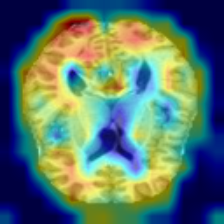

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

K = 400
# target_layers = [trained_model.vit.layernorm]
input_tensor = train_dataset[K][0].unsqueeze(0).to(torch.device('cuda'))

target_layers = [model.vit.encoder.layer[-2].layernorm_before]
# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = cam(input_tensor=input_tensor)
rgb_img = train_dataset[K][0].permute(1, 2, 0).numpy()

# # # In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
from PIL import Image
Image.fromarray(visualization)

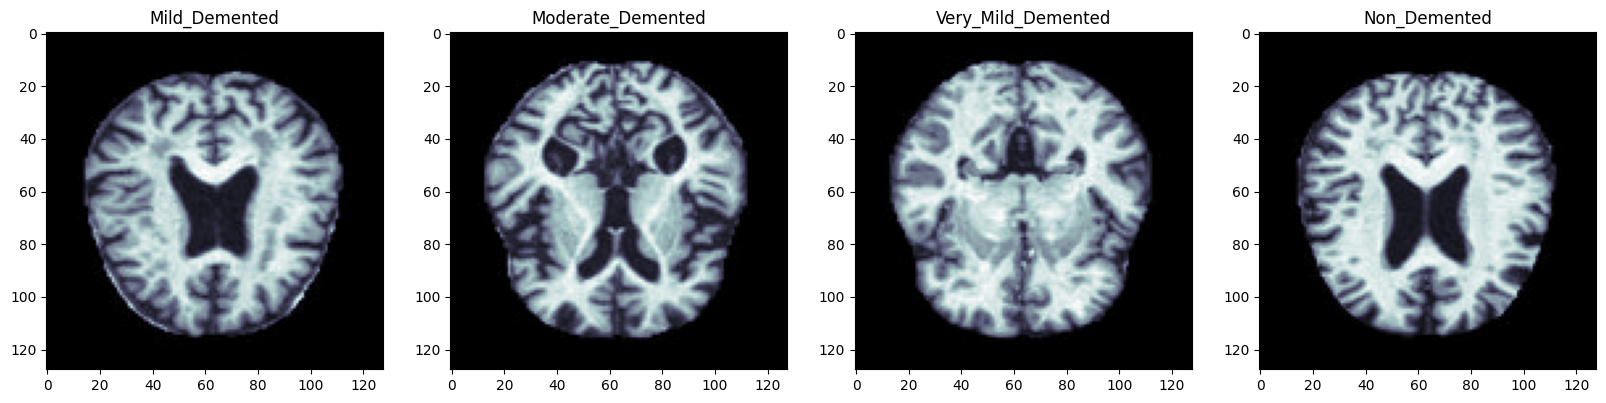

In [ ]:
import matplotlib.pyplot as plt
Categories=['Mild_Demented','Moderate_Demented','Very_Mild_Demented','Non_Demented']
flat_data_arr=[] #input array
target_arr=[] #output array
!pip install -q datasets

from datasets import load_dataset
import os
path=os.path.join(datadir,'Mild_Demented')
# img_array=imread(os.path.join(path,img)
img_array1=imread(os.path.join(path,os.listdir(path)[22]))

path=os.path.join(datadir,'Moderate_Demented')
# img_array=imread(os.path.join(path,img)
img_array2=imread(os.path.join(path,os.listdir(path)[22]))

path=os.path.join(datadir,'Very_Mild_Demented')
# img_array=imread(os.path.join(path,img)
img_array3=imread(os.path.join(path,os.listdir(path)[22]))

path=os.path.join(datadir,'Non_Demented')
# img_array=imread(os.path.join(path,img)
img_array4=imread(os.path.join(path,os.listdir(path)[22]))

## visualize 4 subplots horizontally  img1, img2, img3, img4
import matplotlib.pyplot as plt
import numpy as np

def visualize(img1, img2, img3, img4):
    fig, ax = plt.subplots(1, 4, figsize=(20, 20))
    for i in range(len(Categories)):
      ax[i].set_title(Categories[i])
    ax[0].imshow(img1,cmap=plt.cm.bone)
    ax[1].imshow(img2,cmap=plt.cm.bone)
    ax[2].imshow(img3,cmap=plt.cm.bone)
    ax[3].imshow(img4,cmap=plt.cm.bone)
    plt.show()
visualize(img_array1,img_array2,img_array3,img_array4)